##### Import & Seed:

In [ ]:
# Libraries:
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt
import dill
import sys
import os

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import Lasso

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # include parent directory in the path
from data import SINDy_data
from data import data
from data import equations
from toolbox.auxiliary_functions import set_param_freq

# Seed:
np.random.seed(999)

### Standard:

In [4]:
# Select ODE & settings:
ode_name = 'GompertzODE' # help="name of the ode", type=str
ode_param = '1.5,1.5' # help="parameters of the ode (default: None)", type=str, default=None
freq = 10 # help="sampling frequency", type=float, default=10
dt = 1 / freq
n_sample = 50 # help="number of trajectories", type=int, default=100
noise_ratio = 0.01 # help="noise level (default 0)", type=float, default=0.
dim_x = 1
dim_k = 0
ode_param, freq = set_param_freq(ode_param, freq)
ode = equations.get_ode(ode_name, ode_param)
time_vector = np.arange(0, ode.T + dt, dt)

In [5]:
# generate data:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_ratio, dim_x, dim_k)
print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

# ensure existance conditions:
X_list = SINDy_data.existence_conditions(X_list, ode.init_low, n_variables=dim_x)

# save data:
file_path = 'saved/data/gompertz_data.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'wb') as f:
    dill.dump((X_list, dX_list, param_list, feature_names), f)

(41, 50, 1)
(40, 50, 1)
(40, 50, 1)
(50, 40, 1)
(40, 50, 1)
(50, 40, 1)
(50, 40, 1) (50, 40, 1) (0,)
['X0']


In [6]:
# uploda data:
file_path = 'saved/data/gompertz_data.pkl'
with open(file_path, 'rb') as f:
    X_list, dX_list, param_list, feature_names = dill.load(f)

Threshold:  0.01 , RMSE:  0.014735906814485663
Threshold:  0.05 , RMSE:  0.014735906814485663
Threshold:  0.1 , RMSE:  0.08395516454565775
Threshold:  0.2 , RMSE:  0.08395516454565775
Threshold:  0.4 , RMSE:  0.08395516454565775
Threshold:  0.6 , RMSE:  0.08395516454565775
Threshold:  0.8 , RMSE:  0.18865317624359712


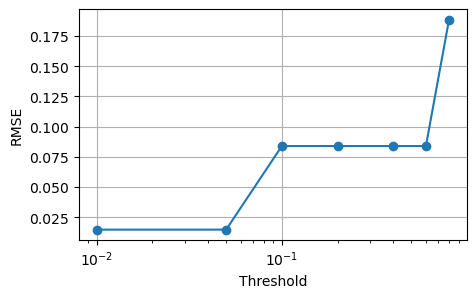

In [ ]:
# model selection:
thresholds = np.array([0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8])
rmse_values = np.zeros(len(thresholds))
for i in range(len(thresholds)):
    model = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=True), optimizer=ps.STLSQ(threshold=thresholds[i]))
    model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)
    rmse, _ = SINDy_data.evaluate_RMSE(model, ode, freq, 10, [0.01], [0.], dim_k)
    rmse_values[i] = rmse
    print('Threshold: ', thresholds[i], ', RMSE: ', rmse)  

plt.figure(figsize=(5, 3))
plt.plot(thresholds, rmse_values, marker='o')
plt.xlabel('Threshold')
plt.ylabel('RMSE')
plt.xscale('log')
plt.grid(True)
plt.show()

# -> best_threshold = 0.05

In [8]:
# best model:
print('')
print('SINDy model:')
polynomial_library = ps.PolynomialLibrary(degree = 3, include_bias=True)
model = ps.SINDy(feature_names  = feature_names, feature_library= polynomial_library, optimizer=ps.STLSQ(threshold=0.05))
model.fit(X_list, t=dt, multiple_trajectories=True, x_dot = dX_list)
model.print()


SINDy model:
(X0)' = 0.047 1 + 2.869 X0 + -7.197 X0^2 + 4.219 X0^3


Best Model RMSE:  0.015666951025103598


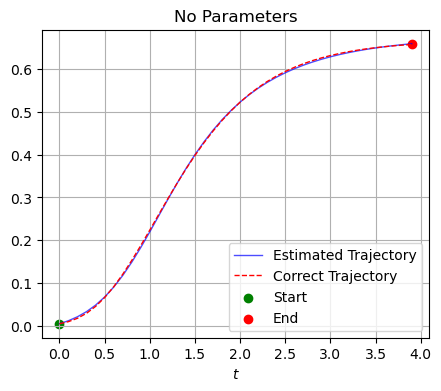

In [9]:
# evaluation
n_sample = 25
rmse, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_sample, [0.01], [0.], dim_k)
print('Best Model RMSE: ', rmse)

n_sample = 1
title = r'No Parameters'
SINDy_data.evaluate_traj(model, ode, freq, n_sample, [0.005], [0.005], dim_x, dim_k, title=title, T_aux = 4)

### Parametrization on $b$

In [2]:
# Select ODE & settings:
ode_name = 'GompertzODE_par_b'
ode_param=None
freq = 10
dt = 1 / freq
n_sample = 50
noise_ratio = 0.01
dim_x = 1
dim_k = 1
ode = equations.get_ode(ode_name, ode_param)
time_vector = np.arange(0, ode.T + dt, dt)

In [3]:
# generate data:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_ratio, dim_x, dim_k)
print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

# ensure existance conditions:
lb = ode.init_low[0] + 0.001
for i in range(np.shape(X_list)[0]):
    for j in range(np.shape(X_list)[1]):
        if X_list[i][j] < 0:
            X_list[i][j] = lb
    #print(X_list[i])

# save data:
file_path = 'saved/data/gompertz_data_b.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'wb') as f:
    dill.dump((X_list, dX_list, param_list, feature_names), f)

(50, 40, 1) (50, 40, 1) (50, 40)
['X0', 'X1']


In [4]:
# uploda data:
file_path = 'saved/data/gompertz_data_b.pkl'
with open(file_path, 'rb') as f:
    X_list, dX_list, param_list, feature_names = dill.load(f)

In [5]:
# SINDy models:
model_0 = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=False), optimizer=ps.STLSQ(threshold=0.1))
model_0.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
model_0.print()
A_0 = model_0.coefficients()
n_features_0 = A_0.shape[1]

model_1 = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=False), optimizer=ps.STLSQ(threshold=0.5))
model_1.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
model_1.print()

model_2 = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=False), optimizer=Lasso(alpha=0.001))
model_2.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
model_2.print()

(X0)' = 5.134 X0 + 0.108 X1 + -6.737 X0^2 + -2.046 X0 X1 + -0.082 X1^2 + 2.935 X0^3 + 0.512 X0^2 X1 + 0.232 X0 X1^2 + 0.023 X1^3
(X0)' = 2.653 X0 + -2.237 X0^2 + 1.674 X0^3 + -1.969 X0^2 X1
(X0)' = 1.738 X0 + -0.078 X1^2 + -1.912 X0^2 X1 + 0.025 X1^3 + 0.223


Threshold:  0.0001 , RMSE:  0.018219084506291734
Threshold:  0.001 , RMSE:  0.018219084506291734
Threshold:  0.01 , RMSE:  0.018219084506291734
Threshold:  0.05 , RMSE:  0.018205165379635662
Threshold:  0.1 , RMSE:  0.186495511114881
Threshold:  0.2 , RMSE:  0.186495511114881
Threshold:  0.4 , RMSE:  0.186495511114881
Threshold:  0.6 , RMSE:  0.186495511114881
Threshold:  0.8 , RMSE:  0.186495511114881


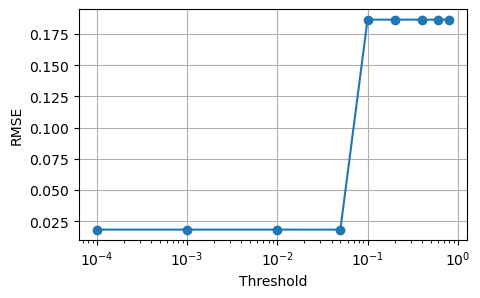

In [ ]:
# model selection:
thresholds = np.array([0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8])
rmse_values = np.zeros(len(thresholds))
for i in range(len(thresholds)):
    model = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=True), optimizer=ps.STLSQ(threshold=thresholds[i]))
    model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
    rmse, _ = SINDy_data.evaluate_RMSE(model, ode, freq, 10, [0.01, 2.0], [0., 1.0], dim_k)
    rmse_values[i] = rmse
    print('Threshold: ', thresholds[i], ', RMSE: ', rmse)  

plt.figure(figsize=(5, 3))
plt.plot(thresholds, rmse_values, marker='o')
plt.xlabel('Threshold')
plt.ylabel('RMSE')
plt.xscale('log')
plt.grid(True)
plt.show()

# -> best_threshold = 0.05

In [7]:
# best model:
best_threshold = 0.05
model_b = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=False), optimizer=ps.STLSQ(threshold=best_threshold))
model_b.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
model_b.print()

(X0)' = 5.134 X0 + 0.108 X1 + -6.737 X0^2 + -2.046 X0 X1 + -0.082 X1^2 + 2.935 X0^3 + 0.512 X0^2 X1 + 0.232 X0 X1^2 + 0.023 X1^3


Best Model RMSE:  0.01452220639454302


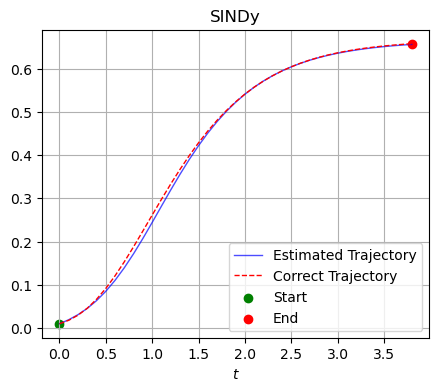

In [8]:
# evaluation:
n_sample = 50
rmse_b, _ = SINDy_data.evaluate_RMSE(model_b, ode, freq, n_sample, [0.01, 2.0], [0., 1.0], dim_k)
print('Best Model RMSE: ', rmse_b)
n_sample = 1
title = 'SINDy'
SINDy_data.evaluate_traj(model_b, ode, freq, n_sample, [0.01, 1.5], [0.01, 1.5], dim_x, dim_k, title=title, T_aux=4)

### Parametrization on $a, b$

In [2]:
# Select ODE & settings:
ode_name = 'GompertzODE_par_ab'
ode_param=None
freq = 10
dt = 1 / freq
n_sample = 50 
noise_ratio = 0.01
dim_x = 1
dim_k = 2
ode = equations.get_ode(ode_name, ode_param)
time_vector = np.arange(0, ode.T + dt, dt)

In [3]:
# generate data:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_ratio, dim_x, dim_k)
print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

# save data:
file_path = 'saved/data/gompertz_data_ab.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'wb') as f:
    dill.dump((X_list, dX_list, param_list, feature_names), f)

(50, 40, 1) (50, 40, 1) (50, 40, 2)
['X0', 'X1', 'X2']


In [4]:
# uploda data:
file_path = 'saved/data/gompertz_data_ab.pkl'
with open(file_path, 'rb') as f:
    X_list, dX_list, param_list, feature_names = dill.load(f)

In [5]:
# SINDy models:
model_0 = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=False), optimizer=ps.STLSQ(threshold=0.01))
model_0.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
model_0.print()
A_0 = model_0.coefficients()
n_features_0 = A_0.shape[1]
# print(A_0)
# print(n_features_0)

model_1 = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=False), optimizer=ps.STLSQ(threshold=0.1))
model_1.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
model_1.print()

model_2 = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=False), optimizer=Lasso(alpha=0.005))
model_2.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
model_2.print()

(X0)' = 1.714 X0 + -0.008 X2 + -3.921 X0^2 + 2.107 X0 X1 + -0.758 X0 X2 + 0.113 X1^2 + -0.136 X1 X2 + 0.051 X2^2 + 2.903 X0^3 + -1.707 X0^2 X1 + 0.365 X0^2 X2 + 0.029 X0 X1^2 + -0.761 X0 X1 X2 + 0.214 X0 X2^2 + -0.005 X1^3 + -0.065 X1^2 X2 + 0.113 X1 X2^2 + -0.041 X2^3
(X0)' = 0.933 X0 + -4.491 X0^2 + 2.632 X0 X1 + 0.048 X0 X2 + 3.894 X0^3 + -2.130 X0^2 X1 + 0.211 X0^2 X2 + -0.789 X0 X1 X2
(X0)' = -0.024 X0^2 X1 + -0.325 X0^2 X2 + 0.011 X1^3 + -0.028 X2^3 + 0.327


Threshold:  0.0001 , RMSE:  0.017793656647565596
Threshold:  0.001 , RMSE:  0.017793656647565596
Threshold:  0.01 , RMSE:  0.016249441697510504
Threshold:  0.05 , RMSE:  0.0971230131127654
Threshold:  0.1 , RMSE:  0.0971230131127654
Threshold:  0.2 , RMSE:  0.0971230131127654
Threshold:  0.4 , RMSE:  0.09582347006890149
Threshold:  0.6 , RMSE:  0.1302913708383787
Threshold:  0.8 , RMSE:  0.1836032204761517


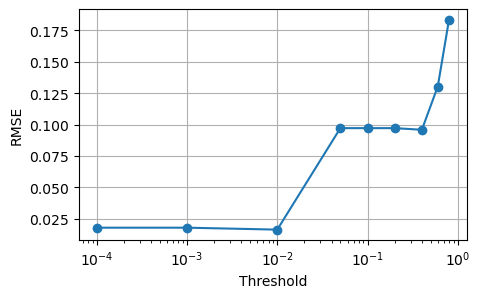

In [7]:
# model selection:
thresholds = np.array([0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8])
rmse_values = np.zeros(len(thresholds))
for i in range(len(thresholds)):
    model = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=False), optimizer=ps.STLSQ(threshold=thresholds[i]))
    model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
    rmse, _ = SINDy_data.evaluate_RMSE(model, ode, freq, 10, [0.01, 2.0, 2.0], [0., 1.0, 1.0], dim_k)
    rmse_values[i] = rmse
    print('Threshold: ', thresholds[i], ', RMSE: ', rmse)
    
plt.figure(figsize=(5, 3))
plt.plot(thresholds, rmse_values, marker='o')
plt.xlabel('Threshold')
plt.ylabel('RMSE')
plt.xscale('log')
plt.grid(True)
plt.show()

# -> best_thresholds: 0.01, 0.4

In [8]:
# best models:

best_threshold_1 = 0.01
model_ab_1 = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=False), optimizer=ps.STLSQ(threshold=best_threshold_1))
model_ab_1.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
model_ab_1.print()

best_threshold_2 = 0.4
model_ab_2 = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=False), optimizer=ps.STLSQ(threshold=best_threshold_2))
model_ab_2.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
model_ab_2.print()

(X0)' = 1.714 X0 + -0.008 X2 + -3.921 X0^2 + 2.107 X0 X1 + -0.758 X0 X2 + 0.113 X1^2 + -0.136 X1 X2 + 0.051 X2^2 + 2.903 X0^3 + -1.707 X0^2 X1 + 0.365 X0^2 X2 + 0.029 X0 X1^2 + -0.761 X0 X1 X2 + 0.214 X0 X2^2 + -0.005 X1^3 + -0.065 X1^2 X2 + 0.113 X1 X2^2 + -0.041 X2^3
(X0)' = 1.035 X0 + -4.587 X0^2 + 2.583 X0 X1 + 3.913 X0^3 + -2.104 X0^2 X1 + 0.235 X0^2 X2 + -0.767 X0 X1 X2


Best Model 1 RMSE:  0.018810623985609648
Best Model 2 RMSE:  0.10793917345226356


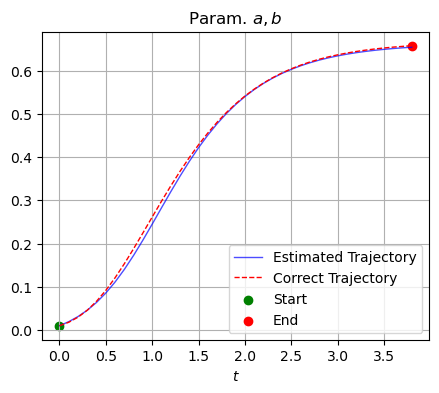

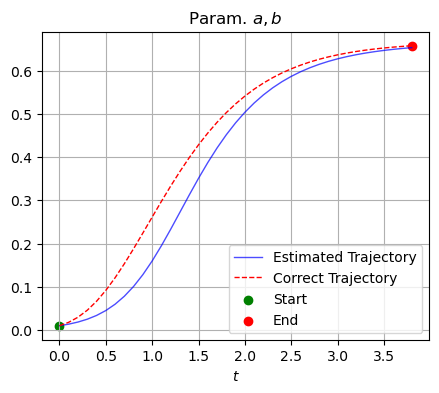

In [9]:
# evaluation:

n_sample = 20
rmse_ab_1, _ = SINDy_data.evaluate_RMSE(model_ab_1, ode, freq, n_sample, [0.01, 2.0, 2.0], [0., 1.0, 1.0], dim_k)
print('Best Model 1 RMSE: ', rmse_ab_1)
rmse_ab_2, _ = SINDy_data.evaluate_RMSE(model_ab_2, ode, freq, n_sample, [0.01, 2.0, 2.0], [0., 1.0, 1.0], dim_k)
print('Best Model 2 RMSE: ', rmse_ab_2)

n_sample = 1
title = 'Param. $a, b$'
SINDy_data.evaluate_traj(model_ab_1, ode, freq, n_sample, [0.01, 1.5, 1.5], [0.01, 1.5, 1.5], dim_x, dim_k, title=title)
SINDy_data.evaluate_traj(model_ab_2, ode, freq, n_sample, [0.01, 1.5, 1.5], [0.01, 1.5, 1.5], dim_x, dim_k, title=title)

Best Model 1 RMSE:  0.7372923786954266


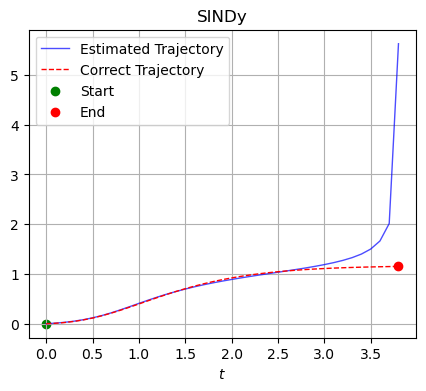

In [10]:
# overfitting issues:
init_point = [0.01, 1.5, 0.85]
n_sample = 3
rmse_ab_1, _ = SINDy_data.evaluate_RMSE(model_ab_1, ode, freq, n_sample, init_point, init_point, dim_k)
print('Best Model 1 RMSE: ', rmse_ab_1)
n_sample = 1
title = 'SINDy'
SINDy_data.evaluate_traj(model_ab_1, ode, freq, n_sample, init_point, init_point, dim_x, dim_k, title=title)

### Results:

Il miglior optimizer pare essere il Sequential Thresholded Least Squares. Il valore della 'threshold' è stato scelto empiricamente per minimizzare l'RMSE tenendo sotto controllo la complessità del modello.

Parametrization on $b$:  
(x)' = 5.123 x + 0.110 k + -6.721 x^2 + -2.040 x k + -0.084 k^2 + 2.929 x^3 + 0.506 x^2 k + 0.231 x k^2 + 0.024 k^3

Parametrization on $a, b$:  
(x)' = 1.714 x + -0.008 k2 + -3.921 x^2 + 2.107 x k1 + -0.758 x k2 + 0.113 k1^2 + -0.136 k1 k2 + 0.051 k2^2 + 2.903 x^3 + -1.707 x^2 k1 + 0.365 x^2 k2 + 0.029 x k1^2 + -0.761 x k1 k2 + 0.214 x k2^2 + -0.005 k1^3 + -0.065 k1^2 k2 + 0.113 k1 k2^2 + -0.041 k2^3  
(x)' = 1.035 x + -4.587 x^2 + 2.583 x k1 + 3.913 x^3 + -2.104 x^2 k1 + 0.235 x^2 k2 + -0.767 x k1 k2

Non essendo presente all'interno della libreria di candidate functions un termine logaritmico, l'unica cosa che SINDy può fare è quella di trovare un'approssimazione polinomiale per il termine logaritmico.  
All'interno del range di training per i parametri il modello è accurato, ma variandolo di poco si manifesta il problema di overfitting. 
E.g. nel caso parametrization on $a, b$, i modelli sono trainati su traiettori aventi parametri nel range [1, 2].  
Testando il miglior modello sul caso b=0.9, per il quale la traiettoria corretta varia molto leggermente, osserviamo che la traiettoria stimata diverge completamente dal comportamento desiderato, mettendo in luce la differenza nella natura dell'ODE trovata, rispetto all'ODE originale.

TODO:  Introdurre termine logaritmico nella libreria?? -> sito salvato mostra come costruire librerie di funzioni customizzate 

### Dev: 

In [ ]:
# Sparse optimization methods:

# Model 0: Sequential Thresholded Least Squares with low threshold -> overfitting
# L'ottimizzatore STLSQ (Sequential Thresholded Least Squares) applica una soglia ai coefficienti ottenuti tramite il metodo dei minimi quadrati
# per ottenere un modello sparso. Dopo aver ottenuto una soluzione iniziale, i coefficienti più piccoli (al di sotto della soglia specificata) 
# vengono impostati a zero, e il processo di stima viene iterato fino a ottenere una convergenza.

# Model 1: Sequential Thresholded Least Squares 
# RMK. conoscendo il risultato corretto, sappiamo che il coefficiente mino che il modello deve individuare è 0.1 -> threshold ~= 0.1

# Model 2: Lasso
# RMK. L'ottimizzatore Lasso (Least Absolute Shrinkage and Selection Operator) introduce una penalizzazione L1 sui coefficienti nel processo 
# di regressione. Questo metodo non solo impone sparseness, ma anche seleziona automaticamente le caratteristiche più rilevanti. 
# La penalizzazione L1 tende a ridurre a zero i coefficienti dei termini meno importanti, eliminandoli dal modello.


# Other methods: 

# Orthogonal Matching Pursuit
# from sklearn.linear_model import OrthogonalMatchingPursuit
# model_omp = ps.SINDy(feature_names=feature_names, 
#                      feature_library=ps.PolynomialLibrary(degree=3, include_bias=False), 
#                      optimizer=OrthogonalMatchingPursuit())
# RMK. Seleziona iterativamente i coefficienti che spiegano la maggior parte della variabilità residua nel modello.

#Sequentially Thresholded Ridge Regression
# model_stridge = ps.SINDy(feature_names=feature_names, 
#                          feature_library=ps.PolynomialLibrary(degree=3, include_bias=False), 
#                          optimizer=ps.STLSQ(threshold=0.08, alpha=1.0))
# Simile a STLSQ, ma utilizza Ridge Regression come base per il processo iterativo di soglia.


# Just in case: automatic definition of 𝝀 parameter for Lasso: aggiungere codice per idividuare the largest 𝝀 value such that the MSE is within one standard error from its minimum (to the right)

In [11]:
# trajectory estimation:   

# true trajectory:
dg_true = data.DataGenerator(ode, ode.T, freq=10, n_sample=1, noise_sigma=0., init_high=[0.01, 1.5, 1.5], init_low=[0.01, 1.5, 1.5])
xt_true = dg_true.xt

#estimated trajectory:
correct_param = [1.5, 1.5]
t = np.arange(0,ode.T,dt)
T_plot = len(t)
test_params = np.tile(correct_param, (T_plot,1))
pred_0 = model_0.simulate(xt_true[0, 0, :][:-dim_k], t= t[:T_plot], u = test_params)
pred_1 = model_1.simulate(xt_true[0, 0, :][:-dim_k], t= t[:T_plot], u = test_params)
pred_2 = model_2.simulate(xt_true[0, 0, :][:-dim_k], t= t[:T_plot], u = test_params)

xt_true = xt_true[:len(pred_0), :, :]
time_vector = time_vector[:len(pred_0)]
xt_true = xt_true[:, :, :-dim_k]
xt_true = xt_true.squeeze()
print(np.shape(xt_true))
print(np.shape(pred_0))
print(np.shape(pred_1))
print(np.shape(pred_2))

(39,)
(39, 1)
(39, 1)
(39, 1)


Model 0 RMSE:  0.006998295114071802
Model 1 RMSE:  0.05139027226078932
Model 2 RMSE:  0.05110020715664048


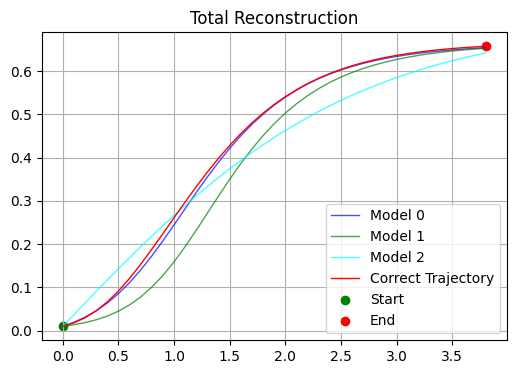

In [13]:
# RMSE:
rmse_0 = root_mean_squared_error(xt_true, pred_0) 
print('Model 0 RMSE: ', rmse_0)
rmse_1 = root_mean_squared_error(xt_true, pred_1)
print('Model 1 RMSE: ', rmse_1)
rmse_2 = root_mean_squared_error(xt_true, pred_2)
print('Model 2 RMSE: ', rmse_2)

# plot:
plt.figure(figsize=(6, 4))

plt.plot(time_vector, pred_0, color='blue', linewidth=1.0, alpha=0.7, label='Model 0')
plt.plot(time_vector, pred_1, color='green', linewidth=1.0, alpha=0.7, label='Model 1')
plt.plot(time_vector, pred_2, color='cyan', linewidth=1.0, alpha=0.7, label='Model 2')

plt.plot(time_vector, xt_true, color='red', linewidth=1.0, label='Correct Trajectory')
plt.scatter(time_vector[0], xt_true[0], color='green', label='Start')
plt.scatter(time_vector[-1], xt_true[-1], color='red', label='End')

plt.title('Total Reconstruction')
plt.legend()
plt.grid(True)

(41, 4, 3)
[2.12900738 0.82531914]
[2.12296881 0.82451259]
[2.1548489  0.97759509]
[2.18179848 0.87358786]
Model 0 RMSE:  [0.06369729070155436, 0.0651984406979506, 0.025152794753415218, 0.03063333741517627]
Model 1 RMSE:  [0.144360235730919, 0.14245514568548542, 0.10826838198869501, 0.11911251449897632]


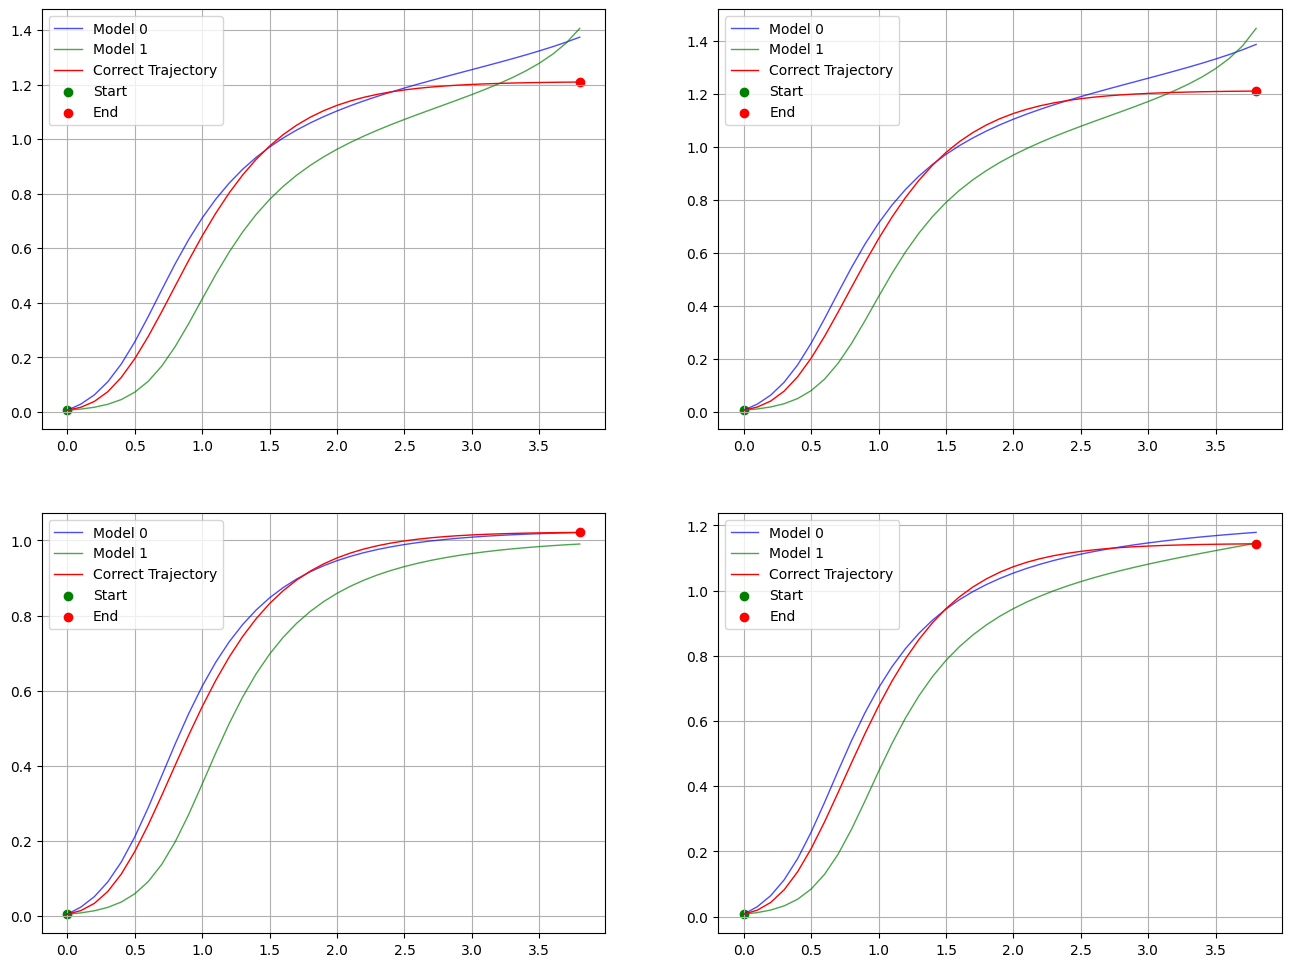

In [8]:
# trajectory estimation:
n_sample = 4  

# true trajectories:
dg_true = data.DataGenerator(ode, ode.T, freq, n_sample, noise_sigma=0., init_high=[0.01, 2.2, 1.0], init_low=[0., 2.0, 0.8])
xt_true = dg_true.xt
print(np.shape(xt_true))

# estimated trajectories:
pred_0_list = []
pred_1_list = []
for i in range(n_sample):
    correct_param = xt_true[0, i, -dim_k:]
    print(correct_param)
    t = np.arange(0,ode.T,dt)
    T_plot = len(t)
    test_params = np.tile(correct_param, (T_plot,1))
    pred_0 = model_0.simulate(xt_true[0, i, :][:-dim_k], t= t[:T_plot], u = test_params)
    pred_1 = model_1.simulate(xt_true[0, i, :][:-dim_k], t= t[:T_plot], u = test_params)
    pred_0_list.append(pred_0)
    pred_1_list.append(pred_1)
         

xt_true = xt_true[:len(pred_0), :, :]
time_vector = time_vector[:len(pred_0)]
xt_true = xt_true[:, :, :-dim_k]
xt_true = xt_true.squeeze()
#print(np.shape(xt_true))
pred_0_list = np.transpose(pred_0_list, (1, 0, 2))
pred_1_list = np.transpose(pred_1_list, (1, 0, 2))
pred_0_list = pred_0_list.squeeze()
pred_1_list = pred_1_list.squeeze()
#print(np.shape(pred_0_list))

# RMSE:
rmse_0_list = []
rmse_1_list = []
for i in range(n_sample):
    rmse_0 = root_mean_squared_error(xt_true[:, i], pred_0_list[:,i]) 
    rmse_1 = root_mean_squared_error(xt_true[:, i], pred_1_list[:,i])
    rmse_0_list.append(rmse_0)
    rmse_1_list.append(rmse_1)
print('Model 0 RMSE: ', rmse_0_list)
print('Model 1 RMSE: ', rmse_1_list)

# plot: 
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.flatten()

for i in range(n_sample):
    axs[i].plot(time_vector, pred_0_list[:, i], color='blue', linewidth=1.0, alpha=0.7, label='Model 0')
    axs[i].plot(time_vector, pred_1_list[:, i], color='green', linewidth=1.0, alpha=0.7, label='Model 1')
    axs[i].plot(time_vector, xt_true[:, i], color='red', linewidth=1.0, label='Correct Trajectory')
    axs[i].scatter(time_vector[0], xt_true[0, i], color='green', label='Start')
    axs[i].scatter(time_vector[-1], xt_true[-1, i], color='red', label='End')
    #axs[i].set_title('Total Reconstruction')
    axs[i].legend()
    axs[i].grid(True)



In [27]:
def test(ode, freq, n_sample, noise_sigma, init_high, init_low, dim_k):

    dg_true = data.DataGenerator(ode, ode.T, freq, n_sample, noise_sigma, init_high, init_low)
    xt_true = dg_true.xt
    print(np.shape(xt_true))

    dt = 1 / freq
    time_vector = np.arange(0, ode.T + dt, dt)
    t = np.arange(0,ode.T,dt)
    T_plot = len(t)


    pred_0_list = []
    rmse_list = []

    for i in range(n_sample):
        correct_param = xt_true[:, i, -dim_k]
        print(correct_param)
        test_params = np.tile(correct_param, (T_plot,1))
        pred_0 = model_0.simulate(xt_true[0, i, :][:-dim_k], t= t[:T_plot], u = test_params)
        pred_0_list.append(pred_0)
         


    xt_true = xt_true[:len(pred_0), :, :]
    time_vector = time_vector[:len(pred_0)]
    xt_true = xt_true[:, :, :-dim_k]
    xt_true = xt_true.squeeze()
    print(np.shape(xt_true))
    print(np.shape(pred_0))
    print(np.shape(pred_1))
    print(np.shape(pred_2))
